Importamos todos los paquetes necesarios para el proyecto:

In [14]:
from robot_search import *
import inspect as ins
from IPython.display import display, HTML

In [15]:
def print_source(func, font_size='10px'):
    try:
        # Get the source code of the function
        source_code = ins.getsource(func)
        # Format the source code as HTML with the specified font size
        html_code = f"<pre style='font-size: {font_size};'>{source_code}</pre>"
        display(HTML(html_code))
    except TypeError:
        print("The provided object is not a valid function.")
    except OSError:
        print("Could not access the source code of the function.")

## Lectura de los datos

In [16]:
print_source(Map)

We read two example maps:

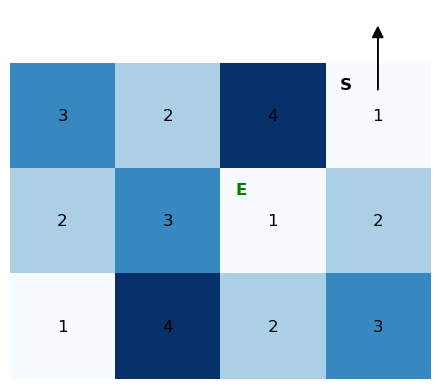

In [17]:
map1 = Map("exampleMap.txt")
map1.draw_initial()

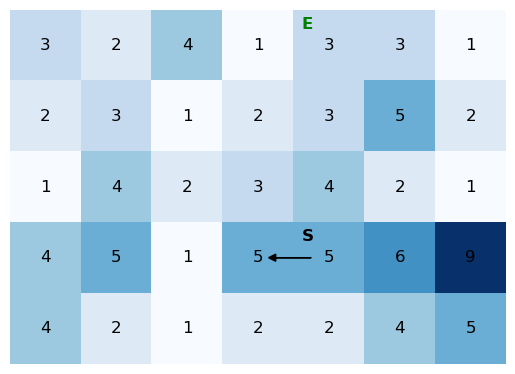

In [18]:
map2 = Map("exampleMap_2.txt")
map2.draw_initial()

In [19]:
print_source(RobotProblem)

In [20]:
robot_problem = RobotProblem(map1)
robot_problem_2 = RobotProblem(map2)

In [21]:
print_source(breadth_first_graph_search)

Coste = 4
Solución = [(0, 3, 0), (0, 3, 7), (0, 3, 6), (0, 3, 5), (1, 2, 5)]
Explorados = [(0, 3, 0), (0, 3, 7), (0, 3, 1), (0, 3, 6), (0, 3, 2), (0, 3, 5)]
Frontera final = [(0, 2, 6), (0, 3, 3), (0, 3, 4)]


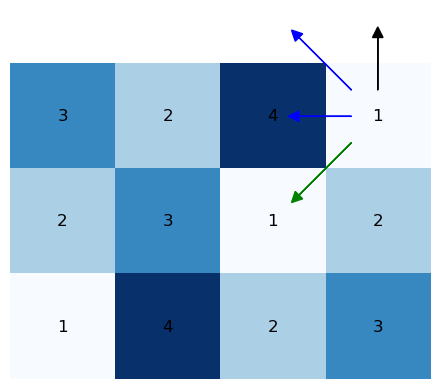

In [22]:
final_node, explored, frontier = breadth_first_graph_search(robot_problem)
cost = final_node.path_cost
frontier = [frontier[i].state for i in range(len(frontier))]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map1.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map1.draw_solution(solution)

Coste = 12
Solución = [(3, 4, 6), (3, 4, 7), (3, 4, 0), (2, 4, 0), (1, 4, 0), (0, 4, 0)]
Explorados = [(3, 4, 6), (3, 4, 5), (3, 4, 7), (3, 3, 6), (3, 4, 4), (4, 3, 5), (3, 4, 0), (2, 3, 7), (3, 3, 5), (3, 3, 7), (3, 2, 6), (3, 4, 3), (4, 4, 4), (4, 3, 4), (4, 3, 6), (3, 4, 1), (2, 4, 0), (2, 3, 6), (2, 3, 0), (1, 2, 7), (3, 3, 4), (4, 2, 5), (3, 3, 0), (2, 2, 7), (3, 2, 5), (3, 2, 7), (3, 1, 6), (3, 4, 2), (4, 5, 3), (4, 4, 3), (4, 4, 5), (4, 3, 3), (4, 3, 7), (4, 2, 6), (2, 5, 1), (2, 4, 7), (2, 4, 1), (1, 4, 0)]
Frontera final = [(2, 3, 5), (2, 2, 6), (2, 3, 1), (1, 3, 0), (1, 2, 6), (1, 2, 0), (0, 1, 7), (3, 3, 3), (4, 2, 4), (3, 3, 1), (2, 2, 0), (1, 1, 7), (3, 2, 4), (4, 1, 5), (3, 2, 0), (2, 1, 7), (3, 1, 5), (3, 1, 7), (3, 0, 6), (3, 5, 2), (4, 5, 2), (4, 5, 4), (4, 4, 2), (4, 4, 6), (4, 3, 2), (4, 3, 0), (4, 2, 7), (4, 1, 6), (2, 5, 0), (2, 5, 2), (1, 6, 1), (2, 4, 6), (1, 3, 7), (2, 4, 2), (1, 5, 1), (1, 4, 7), (1, 4, 1)]


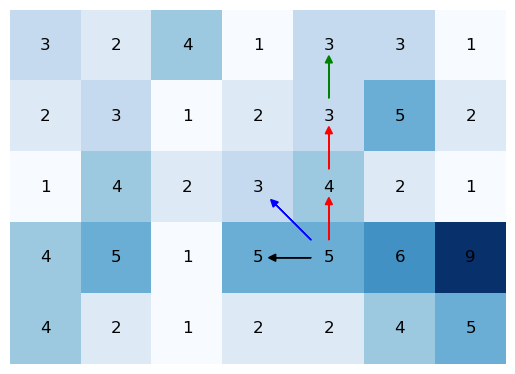

In [23]:
final_node, explored, frontier = breadth_first_graph_search(robot_problem_2)
cost = final_node.path_cost
frontier = [frontier[i].state for i in range(len(frontier))]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map2.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map2.draw_solution(solution)

In [24]:
print_source(depth_first_graph_search)

Coste = 36
Solución = [(0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (1, 3, 4), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 2, 6), (2, 1, 6), (2, 0, 6), (2, 0, 7), (2, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 2), (0, 2, 2), (0, 2, 3), (0, 2, 4), (1, 2, 4)]
Explorados = [(0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (1, 3, 4), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 2, 6), (2, 1, 6), (2, 0, 6), (2, 0, 7), (2, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 2), (0, 2, 2), (0, 2, 3), (0, 2, 4)]
Frontera final = [(0, 3, 7), (0, 3, 5), (1, 3, 3), (1, 3, 5), (2, 3, 3), (2, 3, 7), (2, 2, 5), (2, 2, 7), (2, 1, 5), (2, 1, 7), (2, 0, 5), (2, 0, 1), (1, 0, 7), (1, 0, 1), (0, 0, 7), (0, 0, 3), (0, 1, 1), (0, 1, 3), (0, 2, 1), (0, 2, 5)]


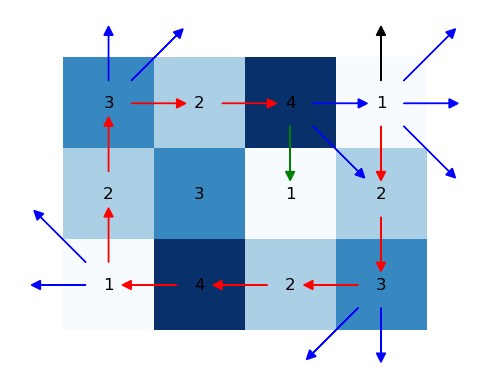

In [25]:
final_node, explored, frontier = depth_first_graph_search(robot_problem)
cost = final_node.path_cost
frontier = [frontier[i].state for i in range(len(frontier))]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map1.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map1.draw_solution(solution)

Coste = 35
Solución = [(3, 4, 6), (3, 3, 6), (3, 2, 6), (3, 1, 6), (3, 0, 6), (3, 0, 7), (3, 0, 0), (2, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 2), (0, 2, 2), (0, 3, 2), (0, 4, 2)]
Explorados = [(3, 4, 6), (3, 3, 6), (3, 2, 6), (3, 1, 6), (3, 0, 6), (3, 0, 7), (3, 0, 0), (2, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 2), (0, 2, 2), (0, 3, 2)]
Frontera final = [(3, 4, 5), (3, 4, 7), (3, 3, 5), (3, 3, 7), (3, 2, 5), (3, 2, 7), (3, 1, 5), (3, 1, 7), (3, 0, 5), (3, 0, 1), (2, 0, 7), (2, 0, 1), (1, 0, 7), (1, 0, 1), (0, 0, 7), (0, 0, 3), (0, 1, 1), (0, 1, 3), (0, 2, 1), (0, 2, 3), (0, 3, 1), (0, 3, 3)]


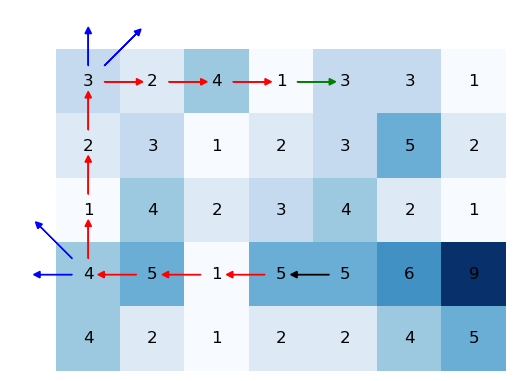

In [26]:
final_node, explored, frontier = depth_first_graph_search(robot_problem_2)
cost = final_node.path_cost
frontier = [frontier[i].state for i in range(len(frontier))]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map2.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map2.draw_solution(solution)

In [28]:
print_source(best_first_graph_search)
print_source(astar_search)

In [30]:
print_source(chebyshev_distance)
print_source(RobotProblem_Chebyshev)

In [31]:
robot_problem_chebyshev = RobotProblem_Chebyshev(map1)
robot_problem_2_chebyshev = RobotProblem_Chebyshev(map2)

Coste = 4
Solución = [(0, 3, 0), (0, 3, 7), (0, 3, 6), (0, 3, 5), (1, 2, 5)]
Explorados = [(0, 3, 0), (0, 3, 1), (0, 3, 7), (0, 3, 2), (0, 3, 6), (0, 3, 3), (0, 3, 5)]
Frontera final = [(0, 3, 4), (0, 2, 6)]


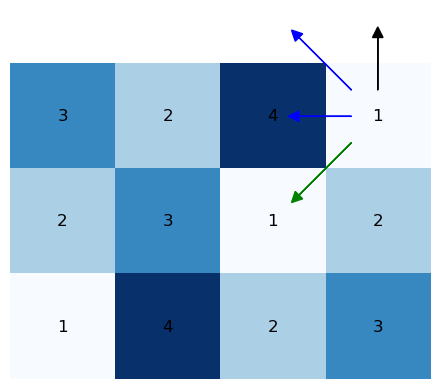

In [32]:
final_node, explored, frontier = astar_search(robot_problem_chebyshev)
cost = final_node.path_cost
frontier = [node.state for _, node in frontier.heap]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map1.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map1.draw_solution(solution)

Coste = 11
Solución = [(3, 4, 6), (3, 4, 7), (2, 3, 7), (2, 3, 0), (1, 3, 0), (1, 3, 1), (0, 4, 1)]
Explorados = [(3, 4, 6), (3, 4, 5), (3, 4, 7), (3, 4, 0), (3, 4, 4), (2, 3, 7), (3, 4, 1), (3, 4, 3), (1, 2, 7), (2, 3, 0), (2, 3, 6), (2, 5, 1), (3, 4, 2), (4, 3, 5), (1, 2, 0), (1, 2, 6), (1, 3, 0), (2, 3, 1), (2, 3, 5), (2, 4, 0), (2, 5, 0), (2, 5, 2), (3, 3, 6), (4, 3, 4), (4, 3, 6), (4, 4, 4), (0, 3, 0), (1, 2, 1), (0, 3, 1), (1, 2, 5), (1, 3, 1), (1, 3, 7), (1, 6, 1), (2, 2, 6), (2, 3, 2), (2, 3, 4), (2, 4, 1), (2, 4, 7), (2, 5, 3), (2, 5, 7), (2, 6, 2), (3, 2, 6), (3, 3, 5), (3, 3, 7), (4, 2, 6), (4, 3, 3), (4, 3, 7), (3, 2, 7), (4, 4, 3), (4, 4, 5), (0, 1, 7), (0, 3, 2), (0, 3, 7), (1, 2, 2), (1, 2, 4), (1, 3, 2), (1, 3, 6), (1, 4, 0), (1, 4, 1), (1, 6, 0), (1, 6, 2), (2, 2, 5), (2, 2, 7), (2, 3, 3), (2, 4, 2), (2, 4, 6), (2, 5, 4), (2, 5, 6), (2, 6, 1), (2, 6, 3), (3, 2, 0), (3, 2, 5), (3, 3, 0), (3, 3, 4), (4, 2, 5), (4, 2, 7), (4, 3, 0), (4, 3, 2), (4, 4, 2), (4, 4, 6), (0, 1,

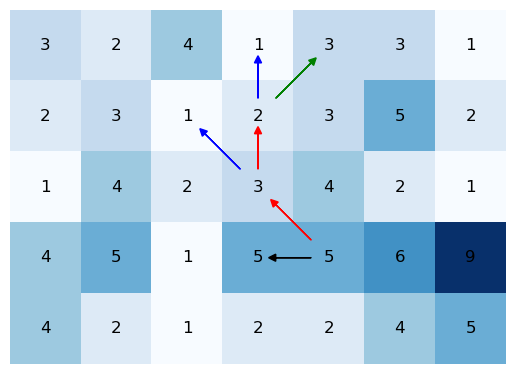

In [33]:
final_node, explored, frontier = astar_search(robot_problem_2_chebyshev)
cost = final_node.path_cost
frontier = [node.state for _, node in frontier.heap]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map2.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map2.draw_solution(solution)

In [34]:
print_source(euclidean_scaled_distance)
print_source(RobotProblem_Euclidean)

In [35]:
robot_problem_euclidean = RobotProblem_Euclidean(map1)
robot_problem_2_euclidean = RobotProblem_Euclidean(map2)

Coste = 4
Solución = [(0, 3, 0), (0, 3, 7), (0, 3, 6), (0, 3, 5), (1, 2, 5)]
Explorados = [(0, 3, 0), (0, 3, 1), (0, 3, 7), (0, 3, 2), (0, 3, 6), (0, 3, 3), (0, 3, 5)]
Frontera final = [(0, 3, 4), (0, 2, 6)]


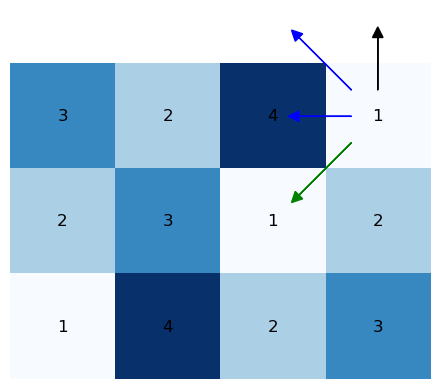

In [36]:
final_node, explored, frontier = astar_search(robot_problem_euclidean)
cost = final_node.path_cost
frontier = [node.state for _, node in frontier.heap]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map1.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map1.draw_solution(solution)

Coste = 11
Solución = [(3, 4, 6), (3, 4, 7), (2, 3, 7), (2, 3, 0), (1, 3, 0), (1, 3, 1), (0, 4, 1)]
Explorados = [(3, 4, 6), (3, 4, 5), (3, 4, 7), (3, 4, 0), (3, 4, 4), (3, 4, 1), (3, 4, 3), (2, 3, 7), (4, 3, 5), (3, 4, 2), (1, 2, 7), (2, 3, 0), (2, 3, 6), (2, 5, 1), (4, 4, 4), (4, 3, 4), (4, 3, 6), (3, 3, 6), (2, 4, 0), (1, 2, 0), (1, 2, 6), (2, 3, 1), (2, 3, 5), (2, 5, 0), (2, 5, 2), (4, 4, 3), (4, 4, 5), (4, 3, 3), (4, 3, 7), (1, 3, 0), (4, 2, 6), (3, 3, 5), (3, 3, 7), (2, 4, 1), (2, 4, 7), (3, 2, 6), (3, 2, 7), (1, 2, 1), (1, 2, 5), (1, 6, 1), (2, 3, 2), (2, 3, 4), (2, 5, 3), (2, 5, 7), (0, 3, 0), (0, 3, 1), (4, 4, 2), (4, 4, 6), (4, 3, 0), (4, 3, 2), (1, 3, 1), (1, 3, 7), (2, 2, 6), (2, 6, 2), (0, 1, 7), (4, 2, 5), (4, 2, 7), (3, 3, 0), (3, 3, 4), (2, 4, 2), (2, 4, 6), (3, 2, 0), (3, 2, 5), (1, 2, 2), (1, 2, 4), (1, 6, 0), (1, 6, 2), (2, 3, 3), (2, 5, 4), (2, 5, 6), (0, 3, 2), (0, 3, 7), (1, 4, 0), (1, 4, 1), (4, 4, 1), (4, 4, 7), (4, 3, 1), (4, 5, 3), (1, 3, 2), (1, 3, 6), (2, 2,

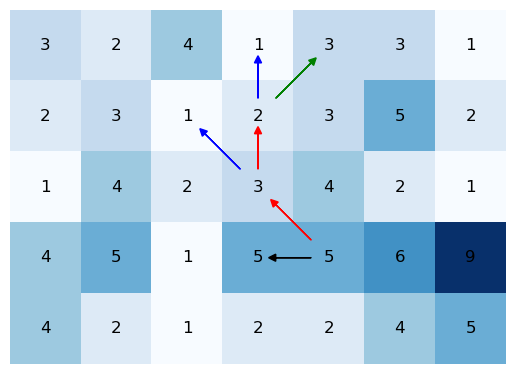

In [37]:
final_node, explored, frontier = astar_search(robot_problem_2_euclidean)
cost = final_node.path_cost
frontier = [node.state for _, node in frontier.heap]
print(f'Coste = ' + str(cost))
solution = final_node.solution()
solution.insert(0, map2.start_position)
print(f'Solución = ' + str(solution))
print(f'Explorados = ' + str(explored))
print(f'Frontera final = ' + str(frontier))
map2.draw_solution(solution)